In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from resnet import Resnet4Channel

In [3]:
bs = 64

In [4]:
path = Path('/home/ben/github/atlas/data/official/')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

In [7]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

In [8]:
src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [9]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test') if fname.endswith('.png')}))

In [11]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [12]:
test_fnames[:5]

[PosixPath('/home/ben/github/atlas/data/official/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/ben/github/atlas/data/official/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/ben/github/atlas/data/official/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('/home/ben/github/atlas/data/official/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('/home/ben/github/atlas/data/official/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [13]:
src.add_test(test_fnames, label='0');

In [14]:
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [15]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [16]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [17]:
data = (src.transform((trn_tfms, _), size=32)
        .databunch().normalize(protein_stats))

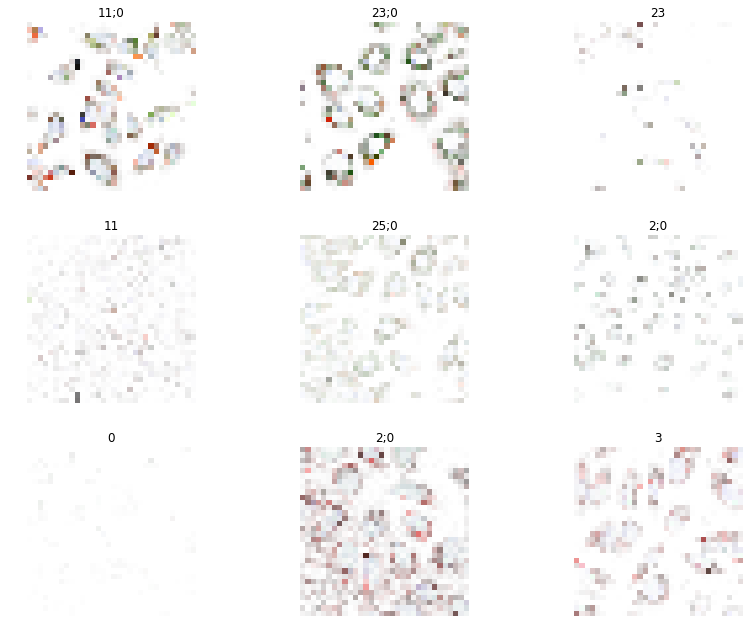

In [18]:
data.show_batch(rows=3, figsize=(12,9))

In [19]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [20]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6],m[1])

In [21]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [22]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


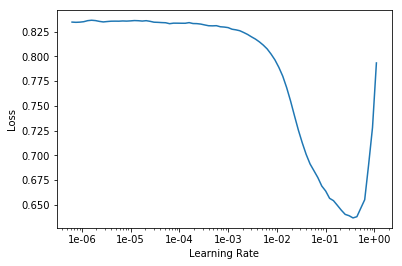

In [24]:
learn.recorder.plot()

In [25]:
lr = 3e-2

In [26]:
learn.fit_one_cycle(5, slice(lr))

Total time: 30:42
epoch  train_loss  valid_loss  fbeta   
1      0.172218    0.167166    0.342372  (06:05)
2      0.169889    0.164685    0.357932  (06:07)
3      0.164005    0.159955    0.375905  (06:06)
4      0.159413    0.155414    0.386670  (06:12)
5      0.156580    0.160069    0.395875  (06:10)



In [27]:
learn.save('stage-1-rn50-datablocks')

In [28]:
learn.unfreeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


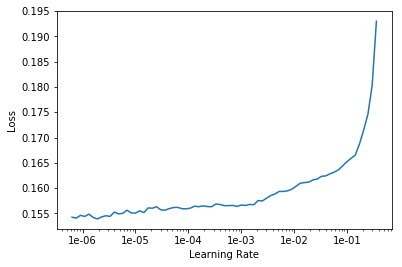

In [30]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(15, slice(3e-5, lr/5))

Total time: 2:37:47
epoch  train_loss  valid_loss  fbeta   
1      0.156914    0.153430    0.394832  (09:26)
2      0.156484    0.201311    0.390679  (09:29)
3      0.156624    0.153960    0.400243  (09:31)
4      0.155957    0.273451    0.397914  (09:44)
5      0.156103    0.160974    0.397694  (09:53)
6      0.156057    0.153275    0.406679  (09:58)
7      0.154171    0.229813    0.399551  (10:05)
8      0.154075    0.160099    0.418377  (10:09)
9      0.153429    0.167601    0.416135  (10:20)
10     0.151739    0.157627    0.427324  (11:33)
11     0.151172    0.155303    0.423908  (11:18)
12     0.150947    0.148260    0.426153  (11:13)
13     0.150806    0.150710    0.428702  (11:18)
14     0.149268    0.155728    0.431768  (12:16)
15     0.147704    0.149111    0.431447  (11:28)



In [32]:
learn.save('stage-2-rn50')

In [33]:
preds,_ = learn.get_preds(DatasetType.Test)

/home/ben/venv_protein/lib/python3.6/site-packages/torch/nn/functional.py:1188: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [38]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.01)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet50_32_th001.csv', header=True, index=False)